<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S6-T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Target:
1.# Increase the accuracy by adding image transformations

#Results:
Parameters: 10.17k

Best Train Accuracy: 99.12

Best Test Accuracy: 99.38

#Analysis:
The model is consistently giving results at 99.38


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args2 = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader2 = torch.utils.data.DataLoader(train, **dataloader_args2)

# test dataloader
test_loader2 = torch.utils.data.DataLoader(test, **dataloader_args2)




CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),            
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

class BatchNorm(nn.BatchNorm2d):
  def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
      super().__init__(num_features, eps=eps, momentum=momentum)
      self.weight.data.fill_(1.0)
      self.bias.data.fill_(0.0)
      self.weight.requires_grad = weight
      self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            GhostBatchNorm(10,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            GhostBatchNorm(10,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(20),
            GhostBatchNorm(20,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            GhostBatchNorm(10,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            GhostBatchNorm(10,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(20),
            GhostBatchNorm(20,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            #nn.BatchNorm2d(10),            
            GhostBatchNorm(10,2),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
            

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
          Dropout-11           [-1, 20, 22, 22]               0
             ReLU-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, model_flag):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if (model_flag != "M1") or (model_flag != "M2") or (model_flag != "M5")or (model_flag != "M6")  :        
        reg_loss = 0
        for param in model.parameters():                
                reg_loss += torch.sum(torch.abs(param))
        factor = 0.0005
        loss += factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,model_flag):
    model.eval()
    test_loss = 0
    correct = 0
    flg = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Saving misclassified Images and their actual and pedicted labels
            tgt = target.view_as(pred)
            comp_df= pred.eq(tgt)
            mis_c = ~comp_df
            if flg == 0:
                misc_im = data[mis_c]
                misc_tr = tgt[mis_c]
                misc_pred = pred[mis_c]
                flg =1
            else:  
                misc_im = torch.cat((data[mis_c],misc_im))
                misc_tr = torch.cat((tgt[mis_c],misc_tr))
                misc_pred = torch.cat((pred[mis_c],misc_pred))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return misc_im,misc_tr,misc_pred

# Let's Train and test our model

In [11]:
from torch.optim.lr_scheduler import StepLR

model_types = ["M1","M2","M3","M4","M5","M6","M7","M8"]
#model_types = ["M1","M2","M3"]
EPOCHS = 25
import pandas as pd
import numpy as np

for model_flag in model_types:
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    #Without L1/L2 with BN
    if model_flag == "M1" :
      model =  Net().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    elif model_flag == "M2" :
      model =  NetGBN().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)      
      
    elif model_flag == "M3" :
      model =  Net().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      
    elif model_flag == "M4" :     
      model =  NetGBN().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)      

    elif model_flag == "M5" :
      model =  Net().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005 )

    elif model_flag == "M6" :
      model =  NetGBN().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005 )      

    elif model_flag == "M7" :
      model =  Net().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005 )

    elif model_flag == "M8" :
      model =  NetGBN().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005 )      
    
        

    for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      if (model_flag == "M2") or (model_flag == "M4") or (model_flag == "M6") or (model_flag == "M8"): 
        train(model, device, train_loader2, optimizer, epoch,model_flag)
      else:
        train(model, device, train_loader, optimizer, epoch,model_flag)

      if model_flag == "M1":
        misc_im,misc_tr,misc_pred = test(model, device, test_loader,model_flag)
      elif model_flag == "M2":
        misc_im_l2,misc_tr_l2,misc_pred_l2 = test(model, device, test_loader,model_flag)
      else:  
        test(model, device, test_loader,model_flag)

    df_list = pd.DataFrame(np.column_stack([test_losses, test_acc]),columns=['test_losses', 'test_acc'])
    df_list['epoch'] = range(0,EPOCHS)    

    
    if (model_flag == "M1"):
      df_list = df_list.rename(columns = {"test_losses": "WO_reg_loss", "test_acc":"WO_reg_Accuracy"})
      df = df_list.copy(deep = True)
    else:
      df_list = df_list.rename(columns = {"test_losses": model_flag+"_loss", "test_acc":model_flag+"_Accuracy"})        
      df = pd.merge(left=df.copy(deep = True), right=df_list.copy(deep = True), how='inner')






  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.4264947175979614 Batch_id=468 Accuracy=91.79: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.26751166582107544 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.3017039895057678 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9812/10000 (98.12%)

EPOCH: 3


Loss=0.19970428943634033 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.30004411935806274 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.22243788838386536 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9789/10000 (97.89%)

EPOCH: 6


Loss=0.2442888617515564 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.3635290265083313 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9853/10000 (98.53%)

EPOCH: 8


Loss=0.24297460913658142 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9853/10000 (98.53%)

EPOCH: 9


Loss=0.25819361209869385 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9838/10000 (98.38%)

EPOCH: 10


Loss=0.16791729629039764 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9879/10000 (98.79%)

EPOCH: 11


Loss=0.27772802114486694 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9859/10000 (98.59%)

EPOCH: 12


Loss=0.16347044706344604 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9843/10000 (98.43%)

EPOCH: 13


Loss=0.1726698875427246 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9807/10000 (98.07%)

EPOCH: 14


Loss=0.23469796776771545 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9860/10000 (98.60%)

EPOCH: 15


Loss=0.15994973480701447 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9898/10000 (98.98%)

EPOCH: 16


Loss=0.15855906903743744 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9835/10000 (98.35%)

EPOCH: 17


Loss=0.1858825385570526 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9878/10000 (98.78%)

EPOCH: 18


Loss=0.13508127629756927 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9871/10000 (98.71%)

EPOCH: 19


Loss=0.13923591375350952 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9870/10000 (98.70%)

EPOCH: 20


Loss=0.15988169610500336 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9873/10000 (98.73%)

EPOCH: 21


Loss=0.16536882519721985 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9899/10000 (98.99%)

EPOCH: 22


Loss=0.15621612966060638 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9867/10000 (98.67%)

EPOCH: 23


Loss=0.18236500024795532 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9888/10000 (98.88%)

EPOCH: 24


Loss=0.19608116149902344 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]



Test set: Average loss: 0.0351, Accuracy: 9898/10000 (98.98%)



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.32001620531082153 Batch_id=937 Accuracy=94.37: 100%|██████████| 938/938 [00:32<00:00, 28.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.3115604817867279 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:32<00:00, 28.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Loss=0.1871854066848755 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:32<00:00, 28.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.19815301895141602 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:32<00:00, 28.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9808/10000 (98.08%)

EPOCH: 4


Loss=0.19991743564605713 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:32<00:00, 28.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


Loss=0.17860224843025208 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:33<00:00, 27.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.19961237907409668 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:33<00:00, 28.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9873/10000 (98.73%)

EPOCH: 7


Loss=0.16404885053634644 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:32<00:00, 28.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9833/10000 (98.33%)

EPOCH: 8


Loss=0.426824688911438 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:32<00:00, 28.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9859/10000 (98.59%)

EPOCH: 9


Loss=0.39156636595726013 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:32<00:00, 28.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9825/10000 (98.25%)

EPOCH: 10


Loss=0.16140128672122955 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:32<00:00, 28.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9859/10000 (98.59%)

EPOCH: 11


Loss=0.18034188449382782 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:32<00:00, 28.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9862/10000 (98.62%)

EPOCH: 12


Loss=0.2957690954208374 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:32<00:00, 28.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9853/10000 (98.53%)

EPOCH: 13


Loss=0.16521351039409637 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:32<00:00, 28.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9814/10000 (98.14%)

EPOCH: 14


Loss=0.19916798174381256 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:33<00:00, 27.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9816/10000 (98.16%)

EPOCH: 15


Loss=0.24058687686920166 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:33<00:00, 27.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9847/10000 (98.47%)

EPOCH: 16


Loss=0.15279480814933777 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:33<00:00, 27.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9750/10000 (97.50%)

EPOCH: 17


Loss=0.13567274808883667 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:33<00:00, 27.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9836/10000 (98.36%)

EPOCH: 18


Loss=0.1322469264268875 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:33<00:00, 27.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9821/10000 (98.21%)

EPOCH: 19


Loss=0.19461359083652496 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:33<00:00, 27.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9798/10000 (97.98%)

EPOCH: 20


Loss=0.15974493324756622 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:32<00:00, 28.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9830/10000 (98.30%)

EPOCH: 21


Loss=0.29213476181030273 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:32<00:00, 28.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9788/10000 (97.88%)

EPOCH: 22


Loss=0.1629740595817566 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:32<00:00, 28.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9888/10000 (98.88%)

EPOCH: 23


Loss=0.23688380420207977 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:32<00:00, 28.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9865/10000 (98.65%)

EPOCH: 24


Loss=0.18602073192596436 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:32<00:00, 28.52it/s]



Test set: Average loss: 0.0668, Accuracy: 9783/10000 (97.83%)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2919541001319885 Batch_id=468 Accuracy=92.67: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.2987205982208252 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.21675711870193481 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:22<00:00, 20.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9836/10000 (98.36%)

EPOCH: 3


Loss=0.19445990025997162 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.28746330738067627 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9848/10000 (98.48%)

EPOCH: 5


Loss=0.16929970681667328 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9771/10000 (97.71%)

EPOCH: 6


Loss=0.16027604043483734 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


Loss=0.20782968401908875 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9853/10000 (98.53%)

EPOCH: 8


Loss=0.15914900600910187 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.16021069884300232 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9862/10000 (98.62%)

EPOCH: 10


Loss=0.2995036244392395 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.20444130897521973 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.19183532893657684 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9894/10000 (98.94%)

EPOCH: 13


Loss=0.213091179728508 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9866/10000 (98.66%)

EPOCH: 14


Loss=0.2632864713668823 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9860/10000 (98.60%)

EPOCH: 15


Loss=0.20575708150863647 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9885/10000 (98.85%)

EPOCH: 16


Loss=0.20625288784503937 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9869/10000 (98.69%)

EPOCH: 17


Loss=0.18150998651981354 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9884/10000 (98.84%)

EPOCH: 18


Loss=0.17557629942893982 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9877/10000 (98.77%)

EPOCH: 19


Loss=0.1593870222568512 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9831/10000 (98.31%)

EPOCH: 20


Loss=0.1719742864370346 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9879/10000 (98.79%)

EPOCH: 21


Loss=0.1764385849237442 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9860/10000 (98.60%)

EPOCH: 22


Loss=0.1716037392616272 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 23


Loss=0.1491607278585434 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9854/10000 (98.54%)

EPOCH: 24


Loss=0.1962476372718811 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]



Test set: Average loss: 0.0465, Accuracy: 9860/10000 (98.60%)



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.4394074082374573 Batch_id=937 Accuracy=94.13: 100%|██████████| 938/938 [00:32<00:00, 28.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.23777158558368683 Batch_id=937 Accuracy=97.38: 100%|██████████| 938/938 [00:34<00:00, 27.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Loss=0.18877345323562622 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:33<00:00, 27.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9804/10000 (98.04%)

EPOCH: 3


Loss=0.25662845373153687 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:32<00:00, 28.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0740, Accuracy: 9745/10000 (97.45%)

EPOCH: 4


Loss=0.22023949027061462 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:33<00:00, 28.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9845/10000 (98.45%)

EPOCH: 5


Loss=0.5020489692687988 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:33<00:00, 28.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9772/10000 (97.72%)

EPOCH: 6


Loss=0.1710805594921112 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:33<00:00, 28.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9841/10000 (98.41%)

EPOCH: 7


Loss=0.19082853198051453 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:32<00:00, 28.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9837/10000 (98.37%)

EPOCH: 8


Loss=0.2934098243713379 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:32<00:00, 28.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9805/10000 (98.05%)

EPOCH: 9


Loss=0.1728517711162567 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:32<00:00, 28.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9840/10000 (98.40%)

EPOCH: 10


Loss=0.23104727268218994 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:32<00:00, 28.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9857/10000 (98.57%)

EPOCH: 11


Loss=0.15970763564109802 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:33<00:00, 27.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9833/10000 (98.33%)

EPOCH: 12


Loss=0.3030419945716858 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:33<00:00, 27.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9846/10000 (98.46%)

EPOCH: 13


Loss=0.24806569516658783 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:32<00:00, 28.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9822/10000 (98.22%)

EPOCH: 14


Loss=0.20778194069862366 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:32<00:00, 28.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9863/10000 (98.63%)

EPOCH: 15


Loss=0.180975079536438 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:32<00:00, 28.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9846/10000 (98.46%)

EPOCH: 16


Loss=0.1397729068994522 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:32<00:00, 28.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9852/10000 (98.52%)

EPOCH: 17


Loss=0.1710823029279709 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:32<00:00, 28.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9794/10000 (97.94%)

EPOCH: 18


Loss=0.14060750603675842 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:33<00:00, 27.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9880/10000 (98.80%)

EPOCH: 19


Loss=0.23746421933174133 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:33<00:00, 27.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9852/10000 (98.52%)

EPOCH: 20


Loss=0.14522558450698853 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:33<00:00, 28.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9841/10000 (98.41%)

EPOCH: 21


Loss=0.2088652104139328 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:33<00:00, 28.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9835/10000 (98.35%)

EPOCH: 22


Loss=0.1576189398765564 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:33<00:00, 28.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9861/10000 (98.61%)

EPOCH: 23


Loss=0.2596808671951294 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:32<00:00, 28.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9867/10000 (98.67%)

EPOCH: 24


Loss=0.16787375509738922 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:33<00:00, 28.37it/s]



Test set: Average loss: 0.0517, Accuracy: 9836/10000 (98.36%)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.33824509382247925 Batch_id=468 Accuracy=92.56: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9803/10000 (98.03%)

EPOCH: 1


Loss=0.22180286049842834 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.26027804613113403 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9837/10000 (98.37%)

EPOCH: 3


Loss=0.2458285391330719 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9848/10000 (98.48%)

EPOCH: 4


Loss=0.16500362753868103 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9840/10000 (98.40%)

EPOCH: 5


Loss=0.2518751621246338 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.18683356046676636 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9880/10000 (98.80%)

EPOCH: 7


Loss=0.16742797195911407 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.21609359979629517 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9868/10000 (98.68%)

EPOCH: 9


Loss=0.1539406031370163 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9854/10000 (98.54%)

EPOCH: 10


Loss=0.14990201592445374 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9899/10000 (98.99%)

EPOCH: 11


Loss=0.17650583386421204 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9862/10000 (98.62%)

EPOCH: 12


Loss=0.21321535110473633 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9878/10000 (98.78%)

EPOCH: 13


Loss=0.1706295609474182 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9877/10000 (98.77%)

EPOCH: 14


Loss=0.21801841259002686 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9885/10000 (98.85%)

EPOCH: 15


Loss=0.22578877210617065 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9896/10000 (98.96%)

EPOCH: 16


Loss=0.22172194719314575 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9890/10000 (98.90%)

EPOCH: 17


Loss=0.17334461212158203 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9867/10000 (98.67%)

EPOCH: 18


Loss=0.12388604134321213 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9866/10000 (98.66%)

EPOCH: 19


Loss=0.12361587584018707 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9869/10000 (98.69%)

EPOCH: 20


Loss=0.15914727747440338 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9884/10000 (98.84%)

EPOCH: 21


Loss=0.25568142533302307 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9862/10000 (98.62%)

EPOCH: 22


Loss=0.15720690786838531 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9891/10000 (98.91%)

EPOCH: 23


Loss=0.18556277453899384 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9895/10000 (98.95%)

EPOCH: 24


Loss=0.14515243470668793 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]



Test set: Average loss: 0.0359, Accuracy: 9887/10000 (98.87%)



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2738850712776184 Batch_id=937 Accuracy=94.35: 100%|██████████| 938/938 [00:32<00:00, 28.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9812/10000 (98.12%)

EPOCH: 1


Loss=0.4130024015903473 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:32<00:00, 28.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9816/10000 (98.16%)

EPOCH: 2


Loss=0.22235196828842163 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:33<00:00, 28.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9840/10000 (98.40%)

EPOCH: 3


Loss=0.34608638286590576 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:33<00:00, 27.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.2966983914375305 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:33<00:00, 28.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9794/10000 (97.94%)

EPOCH: 5


Loss=0.1730077713727951 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:33<00:00, 28.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.5408841371536255 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:33<00:00, 28.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9841/10000 (98.41%)

EPOCH: 7


Loss=0.34913021326065063 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:33<00:00, 27.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Loss=0.20151372253894806 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:33<00:00, 28.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9860/10000 (98.60%)

EPOCH: 9


Loss=0.18698367476463318 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:33<00:00, 28.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9869/10000 (98.69%)

EPOCH: 10


Loss=0.13843177258968353 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:33<00:00, 28.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9840/10000 (98.40%)

EPOCH: 11


Loss=0.14667370915412903 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:32<00:00, 28.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9804/10000 (98.04%)

EPOCH: 12


Loss=0.18030411005020142 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:33<00:00, 28.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Loss=0.1357441395521164 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:32<00:00, 28.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9851/10000 (98.51%)

EPOCH: 14


Loss=0.13146400451660156 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:33<00:00, 28.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9875/10000 (98.75%)

EPOCH: 15


Loss=0.14148002862930298 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:33<00:00, 28.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9883/10000 (98.83%)

EPOCH: 16


Loss=0.14444756507873535 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:33<00:00, 28.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9854/10000 (98.54%)

EPOCH: 17


Loss=0.33787378668785095 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:33<00:00, 27.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9840/10000 (98.40%)

EPOCH: 18


Loss=0.23858454823493958 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:33<00:00, 27.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9817/10000 (98.17%)

EPOCH: 19


Loss=0.2163429707288742 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:33<00:00, 28.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9847/10000 (98.47%)

EPOCH: 20


Loss=0.16868185997009277 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:33<00:00, 28.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9864/10000 (98.64%)

EPOCH: 21


Loss=0.13055047392845154 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:33<00:00, 28.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9846/10000 (98.46%)

EPOCH: 22


Loss=0.1328887641429901 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:32<00:00, 28.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9874/10000 (98.74%)

EPOCH: 23


Loss=0.13313668966293335 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:32<00:00, 28.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9840/10000 (98.40%)

EPOCH: 24


Loss=0.13258633017539978 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:32<00:00, 28.62it/s]



Test set: Average loss: 0.0558, Accuracy: 9846/10000 (98.46%)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3162972331047058 Batch_id=468 Accuracy=92.07: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.24925506114959717 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.357584685087204 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9823/10000 (98.23%)

EPOCH: 3


Loss=0.24436327815055847 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9818/10000 (98.18%)

EPOCH: 4


Loss=0.2398577630519867 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


Loss=0.17185983061790466 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9846/10000 (98.46%)

EPOCH: 6


Loss=0.24242627620697021 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9837/10000 (98.37%)

EPOCH: 7


Loss=0.224563866853714 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9871/10000 (98.71%)

EPOCH: 8


Loss=0.24410700798034668 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9882/10000 (98.82%)

EPOCH: 9


Loss=0.16272222995758057 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9849/10000 (98.49%)

EPOCH: 10


Loss=0.16707558929920197 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9899/10000 (98.99%)

EPOCH: 11


Loss=0.17699924111366272 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9860/10000 (98.60%)

EPOCH: 12


Loss=0.2060592621564865 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9849/10000 (98.49%)

EPOCH: 13


Loss=0.17542868852615356 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9836/10000 (98.36%)

EPOCH: 14


Loss=0.2397979199886322 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9864/10000 (98.64%)

EPOCH: 15


Loss=0.1321229338645935 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9894/10000 (98.94%)

EPOCH: 16


Loss=0.16681858897209167 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9873/10000 (98.73%)

EPOCH: 17


Loss=0.17801469564437866 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9887/10000 (98.87%)

EPOCH: 18


Loss=0.159244567155838 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9873/10000 (98.73%)

EPOCH: 19


Loss=0.18915745615959167 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9877/10000 (98.77%)

EPOCH: 20


Loss=0.14950093626976013 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

EPOCH: 21


Loss=0.12715229392051697 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9830/10000 (98.30%)

EPOCH: 22


Loss=0.11189453303813934 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9880/10000 (98.80%)

EPOCH: 23


Loss=0.14152489602565765 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9857/10000 (98.57%)

EPOCH: 24


Loss=0.1659024953842163 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0360, Accuracy: 9891/10000 (98.91%)



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.338981568813324 Batch_id=937 Accuracy=94.37: 100%|██████████| 938/938 [00:32<00:00, 28.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9827/10000 (98.27%)

EPOCH: 1


Loss=0.2550220489501953 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:33<00:00, 28.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9791/10000 (97.91%)

EPOCH: 2


Loss=0.17435593903064728 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:33<00:00, 28.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9832/10000 (98.32%)

EPOCH: 3


Loss=0.3406175374984741 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:33<00:00, 28.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.1541263312101364 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:33<00:00, 27.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


Loss=0.15633709728717804 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:33<00:00, 27.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9869/10000 (98.69%)

EPOCH: 6


Loss=0.17107054591178894 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:34<00:00, 27.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9848/10000 (98.48%)

EPOCH: 7


Loss=0.14641651511192322 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:34<00:00, 27.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9868/10000 (98.68%)

EPOCH: 8


Loss=0.2435854822397232 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:34<00:00, 27.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9849/10000 (98.49%)

EPOCH: 9


Loss=0.20181749761104584 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:34<00:00, 27.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9859/10000 (98.59%)

EPOCH: 10


Loss=0.37148144841194153 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:33<00:00, 28.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9859/10000 (98.59%)

EPOCH: 11


Loss=0.15088626742362976 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:33<00:00, 27.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9848/10000 (98.48%)

EPOCH: 12


Loss=0.14034894108772278 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:33<00:00, 28.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9866/10000 (98.66%)

EPOCH: 13


Loss=0.1597995162010193 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:33<00:00, 28.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Accuracy: 9747/10000 (97.47%)

EPOCH: 14


Loss=0.13178777694702148 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:33<00:00, 28.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9871/10000 (98.71%)

EPOCH: 15


Loss=0.21776264905929565 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:33<00:00, 28.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9826/10000 (98.26%)

EPOCH: 16


Loss=0.15311607718467712 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:33<00:00, 28.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9848/10000 (98.48%)

EPOCH: 17


Loss=0.3486996293067932 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:33<00:00, 28.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9783/10000 (97.83%)

EPOCH: 18


Loss=0.26357609033584595 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:33<00:00, 28.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9836/10000 (98.36%)

EPOCH: 19


Loss=0.3872567117214203 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:33<00:00, 28.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9850/10000 (98.50%)

EPOCH: 20


Loss=0.12702512741088867 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:33<00:00, 28.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9847/10000 (98.47%)

EPOCH: 21


Loss=0.12952443957328796 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:33<00:00, 28.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9849/10000 (98.49%)

EPOCH: 22


Loss=0.14202100038528442 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:33<00:00, 28.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9858/10000 (98.58%)

EPOCH: 23


Loss=0.18113137781620026 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:33<00:00, 28.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9845/10000 (98.45%)

EPOCH: 24


Loss=0.17174005508422852 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:33<00:00, 28.23it/s]



Test set: Average loss: 0.0458, Accuracy: 9857/10000 (98.57%)



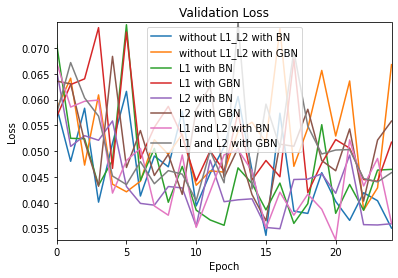

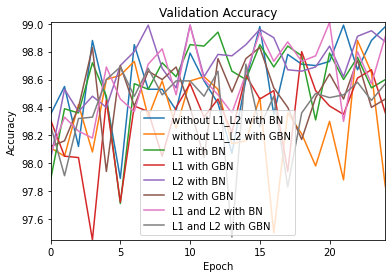

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df['WO_reg_loss'],label='without L1_L2 with BN')
ax.plot(df['M2_loss'],label='without L1_L2 with GBN')
ax.plot(df['M3_loss'],label='L1 with BN')
ax.plot(df['M4_loss'],label='L1 with GBN')
ax.plot(df['M5_loss'], label='L2 with BN')
ax.plot(df['M6_loss'], label='L2 with GBN')
ax.plot(df['M7_loss'], label='L1 and L2 with BN')
ax.plot(df['M8_loss'], label='L1 and L2 with GBN')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
leg = ax.legend();

from google.colab import files
plt.savefig("validation_loss.png")
files.download("validation_loss.png")

fig, ax = plt.subplots()
ax.plot(df['WO_reg_Accuracy'],label='without L1_L2 with BN')
ax.plot(df['M2_Accuracy'],label='without L1_L2 with GBN')
ax.plot(df['M3_Accuracy'],label='L1 with BN')
ax.plot(df['M4_Accuracy'],label='L1 with GBN')
ax.plot(df['M5_Accuracy'], label='L2 with BN')
ax.plot(df['M6_Accuracy'], label='L2 with GBN')
ax.plot(df['M7_Accuracy'], label='L1 and L2 with BN')
ax.plot(df['M8_Accuracy'], label='L1 and L2 with GBN')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

from google.colab import files
plt.savefig("Validation_Accuracy.png")
files.download("Validation_Accuracy.png")

torch.Size([217, 28, 28])
torch.Size([102, 28, 28])
torch.Size([217])
torch.Size([102])
torch.Size([217])
torch.Size([102])


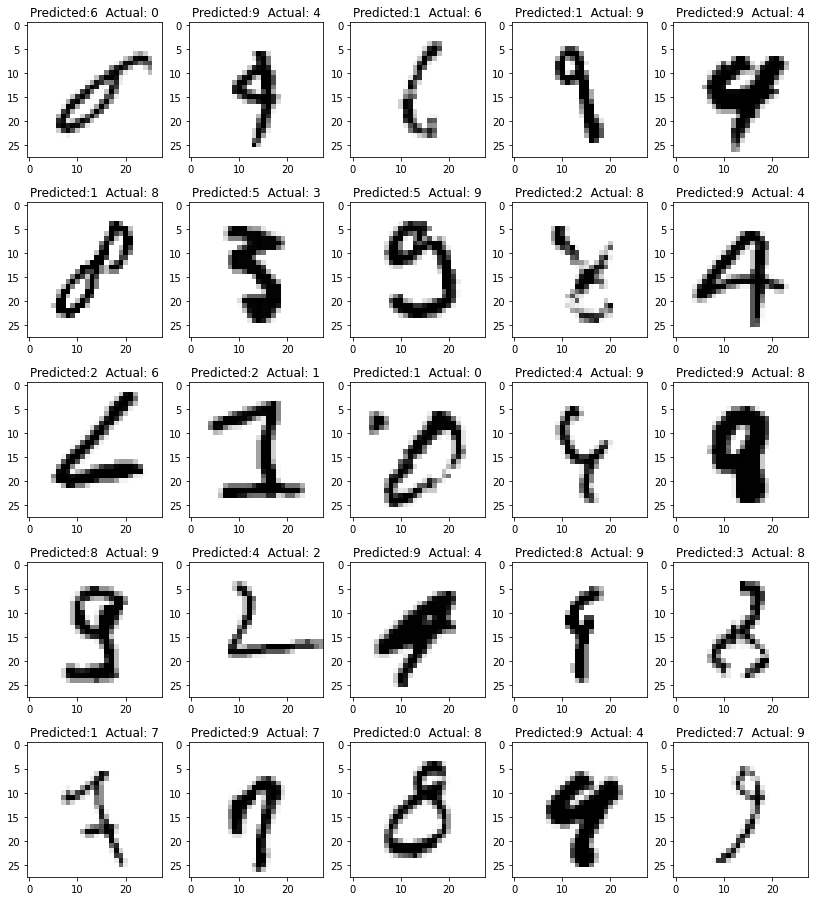

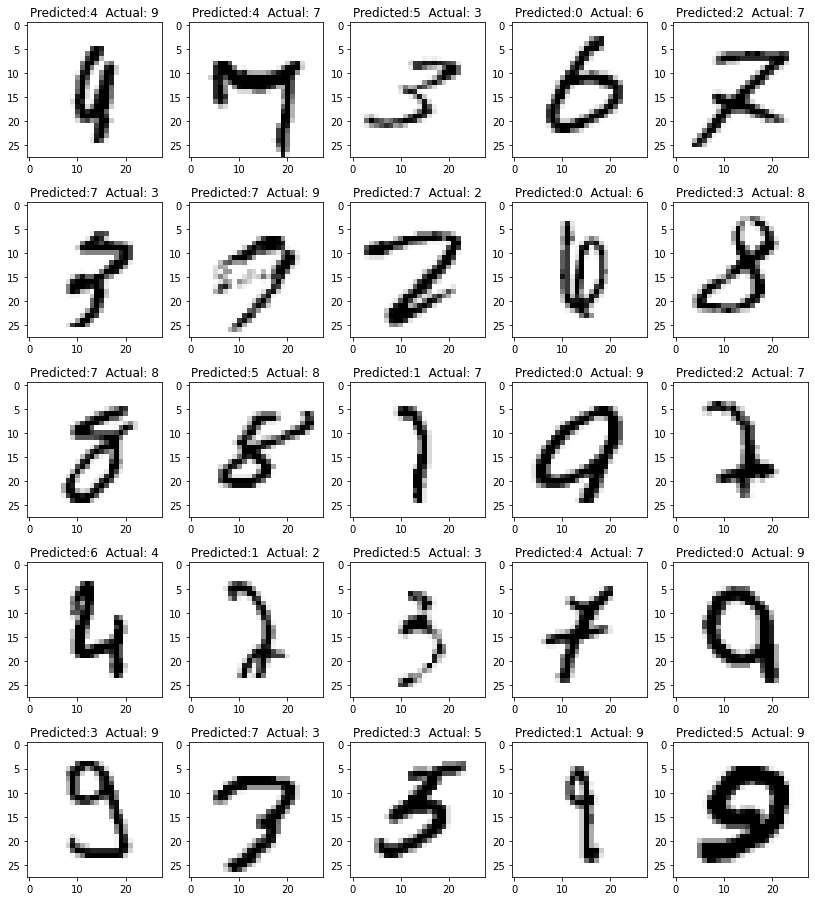

In [13]:
print(misc_im_l2.shape)
print(misc_im.shape)
print(misc_tr_l2.shape)
print(misc_tr.shape)
print(misc_pred_l2.shape)
print(misc_pred.shape)
%matplotlib inline
import matplotlib.pyplot as plt 

fig=plt.figure(figsize=(14, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = misc_im[i-1].to(torch.device("cpu"))
    p = misc_pred[i-1].to(torch.device("cpu"))
    t = misc_tr[i-1].to(torch.device("cpu"))
    #img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img[:, :, 0].numpy().squeeze(),cmap='gray_r')
    plt.imshow(img.numpy().squeeze(),cmap='gray_r')
    plt.title("Predicted:"+str(p)[7:8]+"  Actual: "+str(t)[7:8])
#plt.show()
from google.colab import files
plt.savefig("L1_Misclassified_Images.png")
files.download("L1_Misclassified_Images.png")

fig=plt.figure(figsize=(14, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = misc_im_l2[i-1].to(torch.device("cpu"))
    p = misc_pred_l2[i-1].to(torch.device("cpu"))
    t = misc_tr_l2[i-1].to(torch.device("cpu"))
    #img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img[:, :, 0].numpy().squeeze(),cmap='gray_r')
    plt.imshow(img.numpy().squeeze(),cmap='gray_r')
    plt.title("Predicted:"+str(p)[7:8]+"  Actual: "+str(t)[7:8])
#plt.show()

from google.colab import files
plt.savefig("L2_Misclassified_Images.png")
files.download("L2_Misclassified_Images.png")